In [ ]:
!pip install datasets
!pip install transformers
!pip install sklearn
!pip install peft
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 req

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, DataCollatorWithPadding, AlbertTokenizer, AlbertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import seaborn as sns
import pandas as pd

# 1. Dữ liệu

In [ ]:
dataset = load_dataset("stsb_multi_mt", "en")

train_dataset = dataset['train']
validation_dataset = dataset['dev']
test_dataset = dataset['test']

In [ ]:
df_train = pd.DataFrame(train_dataset)
df_train.head()

,sentence1,sentence2,similarity_score
0,A plane is taking off.,An air plane is taking off.,5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,Three men are playing chess.,Two men are playing chess.,2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5749 entries, 0 to 5748
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sentence1         5749 non-null   object 
 1   sentence2         5749 non-null   object 
 2   similarity_score  5749 non-null   float64
dtypes: float64(1), object(2)
memory usage: 134.9+ KB


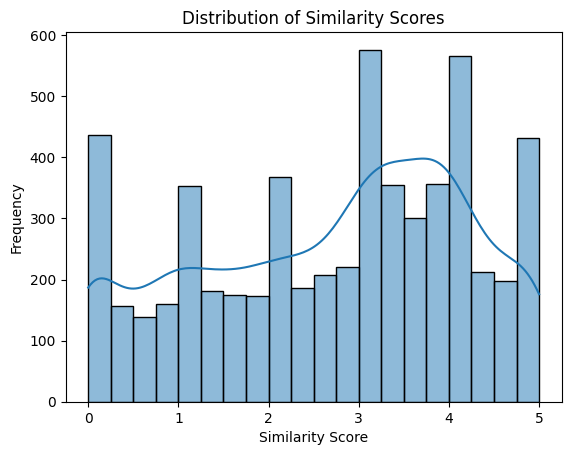

In [ ]:
# Kiểm tra phân phối của các điểm số similarity_score
sns.histplot(df_train['similarity_score'], kde=True)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Phân tích độ dài của câu trong sentence1 và sentence2
df_train['len_sentence1'] = df_train['sentence1'].apply(lambda x: len(x.split()))
df_train['len_sentence2'] = df_train['sentence2'].apply(lambda x: len(x.split()))

# Hiển thị thông tin thống kê cơ bản về độ dài câu
print(df_train[['len_sentence1', 'len_sentence2']].describe())

       len_sentence1  len_sentence2
count    5749.000000    5749.000000
mean        9.950774       9.938946
std         5.456111       5.356750
min         3.000000       2.000000
25%         6.000000       6.000000
50%         8.000000       8.000000
75%        11.000000      12.000000
max        56.000000      48.000000


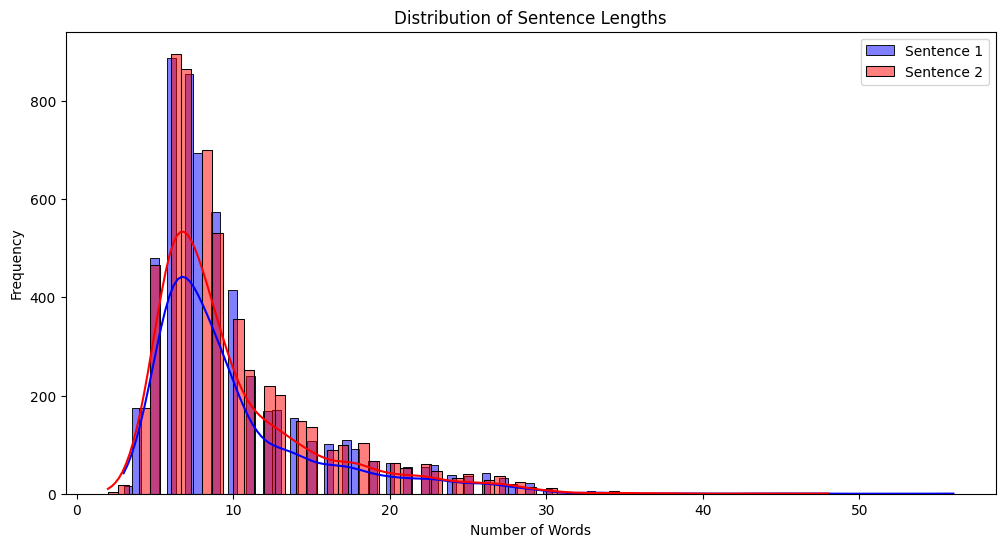

In [ ]:
# Phân phối độ dài của sentence1 và sentence2
plt.figure(figsize=(12, 6))
sns.histplot(df_train['len_sentence1'], color='blue', label='Sentence 1', kde=True)
sns.histplot(df_train['len_sentence2'], color='red', label='Sentence 2', kde=True)
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['sentence1'], examples['sentence2'], truncation=True)

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [ ]:
# Ensure labels are floats
train_dataset = train_dataset.map(lambda x: {'labels': x['similarity_score']})
validation_dataset = validation_dataset.map(lambda x: {'labels': x['similarity_score']})
test_dataset = test_dataset.map(lambda x: {'labels': x['similarity_score']})

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [ ]:
df_train_tk = pd.DataFrame(train_dataset)
df_train_tk.head()

,sentence1,sentence2,similarity_score,input_ids,attention_mask,labels
0,A plane is taking off.,An air plane is taking off.,5.00,"[0, 250, 3286, 16, 602, 160, 4, 2, 2, 4688, 93...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80,"[0, 250, 313, 16, 816, 10, 739, 2342, 4467, 4,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80,"[0, 250, 313, 16, 9592, 27373, 196, 7134, 15, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.80
3,Three men are playing chess.,Two men are playing chess.,2.60,"[0, 15622, 604, 32, 816, 25109, 4, 2, 2, 9058,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25,"[0, 250, 313, 16, 816, 5, 3551, 139, 4, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.25


# 2. Mô hình

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=1)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.749460
2,0.861400,0.667658
3,0.321200,0.410394
4,0.321200,0.421330
5,0.201100,0.429445


TrainOutput(global_step=1800, training_loss=0.4100452931722005, metrics={'train_runtime': 521.5518, 'train_samples_per_second': 55.114, 'train_steps_per_second': 3.451, 'total_flos': 938202946823694.0, 'train_loss': 0.4100452931722005, 'epoch': 5.0})

In [ ]:
# Evaluate the model on the val set
eval_results = trainer.evaluate(validation_dataset)

print(f"Evaluation results: {eval_results}")


Evaluation results: {'eval_loss': 0.42944473028182983, 'eval_runtime': 4.0467, 'eval_samples_per_second': 370.673, 'eval_steps_per_second': 23.229, 'epoch': 5.0}


# 3. Đánh giá

In [ ]:
predictions_output = trainer.predict(validation_dataset)
predictions = predictions_output.predictions

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from scipy.stats import pearsonr, spearmanr

# Giả định rằng bạn đã có predictions từ mô hình của mình
# predictions = trainer.predict(validation_dataset).predictions

# MSE
mse = mean_squared_error(validation_dataset['similarity_score'], predictions)
print(f"Mean Squared Error (MSE): {mse}")

# RMSE
rmse = mean_squared_error(validation_dataset['similarity_score'], predictions, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# MAE
mae = mean_absolute_error(validation_dataset['similarity_score'], predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(validation_dataset['similarity_score'], predictions)
print(f"R-squared (R²): {r2}")

# Spearman's Rank Correlation
spearman_corr, _ = spearmanr(validation_dataset['similarity_score'], predictions)
print(f"Spearman's Rank Correlation: {spearman_corr}")

# Explained Variance Score
evs = explained_variance_score(validation_dataset['similarity_score'], predictions)
print(f"Explained Variance Score: {evs}")

Mean Squared Error (MSE): 0.4294447240341703
Root Mean Squared Error (RMSE): 0.6553203217008994
Mean Absolute Error (MAE): 0.4964411508391301
R-squared (R²): 0.8091319626931506
Spearman's Rank Correlation: 0.9051721675437648
Explained Variance Score: 0.8180735750578381


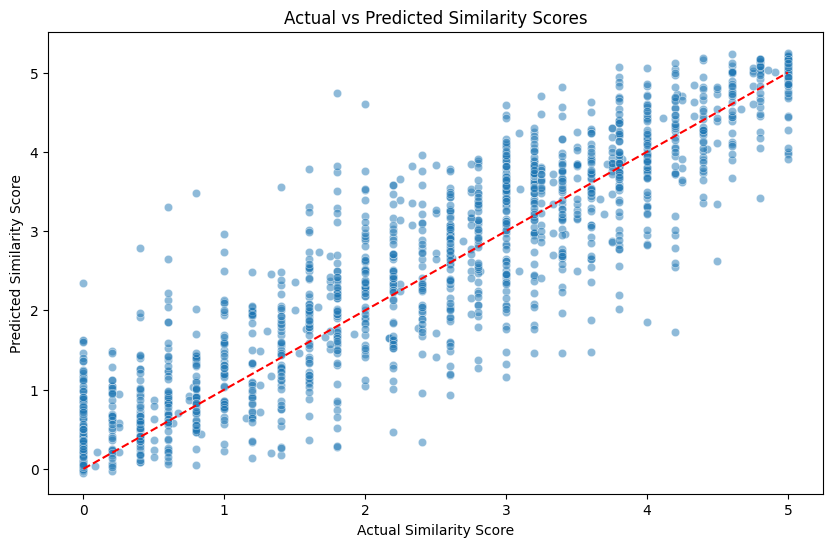

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

preds = np.squeeze(predictions)

# Scatter plot giữa giá trị thực tế và giá trị dự đoán
plt.figure(figsize=(10, 6))
sns.scatterplot(x=validation_dataset['similarity_score'], y=preds, alpha=0.5)
plt.plot([0, 5], [0, 5], color='red', linestyle='--')
plt.title('Actual vs Predicted Similarity Scores')
plt.xlabel('Actual Similarity Score')
plt.ylabel('Predicted Similarity Score')
plt.show()

* 0 <= score < 1 -> Class 0
* 1 <= score < 2 -> Class 1
* 2 <= score < 3 -> Class 2
* 3 <= score < 4 -> Class 3
* 4 <= score <= 5 -> Class 4

In [ ]:
# Chuyển đổi điểm số similarity thành các labels
def convert_to_labels(scores):
    labels = []
    for score in scores:
        if score < 1:
            labels.append(0)
        elif score < 2:
            labels.append(1)
        elif score < 3:
            labels.append(2)
        elif score < 4:
            labels.append(3)
        else:
            labels.append(4)
    return np.array(labels)

# Chuyển đổi cả actual và predicted similarity scores thành labels
actual_labels = convert_to_labels(validation_dataset['similarity_score'])
predicted_labels = convert_to_labels(predictions)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Tính toán Accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Tính toán F1 Score
f1 = f1_score(actual_labels, predicted_labels, average='weighted')  # average='weighted' để tính F1 trung bình có trọng số
print(f"F1 Score (Weighted): {f1}")

# Tạo Confusion Matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# In báo cáo chi tiết (bao gồm Precision, Recall và F1 Score cho từng lớp)
report = classification_report(actual_labels, predicted_labels)
print("Classification Report:")
print(report)

Accuracy: 0.6266666666666667
F1 Score (Weighted): 0.6290267370842727
Confusion Matrix:
[[267  68   7   2   0]
 [ 54 127  61  11   1]
 [  4  58 132  78   1]
 [  0  13  74 217  61]
 [  0   2   8  57 197]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       344
           1       0.47      0.50      0.49       254
           2       0.47      0.48      0.48       273
           3       0.59      0.59      0.59       365
           4       0.76      0.75      0.75       264

    accuracy                           0.63      1500
   macro avg       0.62      0.62      0.62      1500
weighted avg       0.63      0.63      0.63      1500



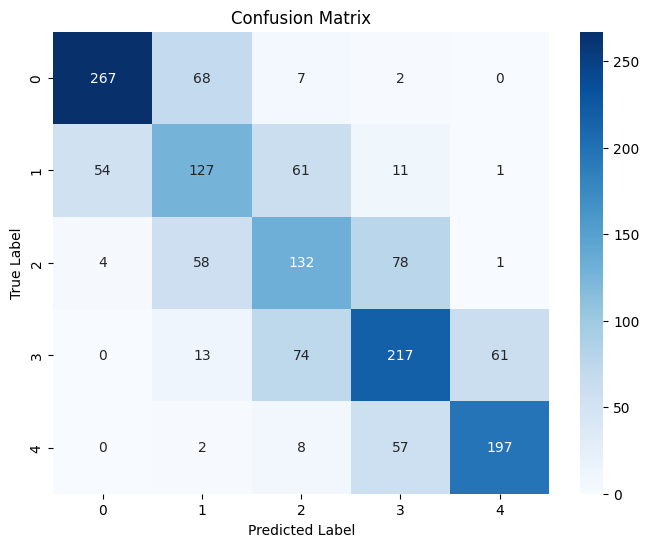

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Đánh giá tập test

In [ ]:
predictions_output = trainer.predict(test_dataset)
predictions = predictions_output.predictions

# Chuyển đổi điểm số similarity thành các labels
def convert_to_labels(scores):
    labels = []
    for score in scores:
        if score < 1:
            labels.append(0)
        elif score < 2:
            labels.append(1)
        elif score < 3:
            labels.append(2)
        elif score < 4:
            labels.append(3)
        else:
            labels.append(4)
    return np.array(labels)

# Chuyển đổi cả actual và predicted similarity scores thành labels
actual_labels = convert_to_labels(test_dataset['similarity_score'])
predicted_labels = convert_to_labels(predictions)

In [ ]:
# Tính toán Accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Tính toán F1 Score
f1 = f1_score(actual_labels, predicted_labels, average='weighted')  # average='weighted' để tính F1 trung bình có trọng số
print(f"F1 Score (Weighted): {f1}")

# Tạo Confusion Matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# In báo cáo chi tiết (bao gồm Precision, Recall và F1 Score cho từng lớp)
report = classification_report(actual_labels, predicted_labels)
print("Classification Report:")
print(report)

Accuracy: 0.6033357505438723
F1 Score (Weighted): 0.6054251893307123
Confusion Matrix:
[[195  43   4   1   0]
 [ 32  94  68   3   1]
 [  5  68  97  88   7]
 [  0  10  57 210  58]
 [  0   3  13  86 236]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       243
           1       0.43      0.47      0.45       198
           2       0.41      0.37      0.38       265
           3       0.54      0.63      0.58       335
           4       0.78      0.70      0.74       338

    accuracy                           0.60      1379
   macro avg       0.60      0.59      0.60      1379
weighted avg       0.61      0.60      0.61      1379



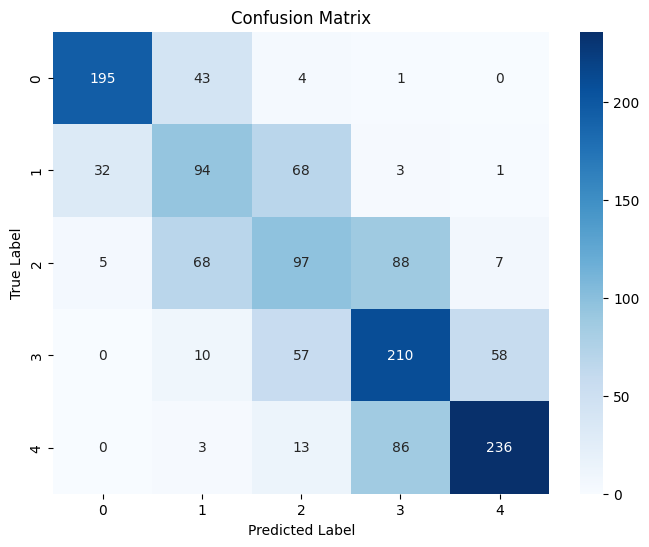

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()